In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


### Toybox-12 clear and blur accuracy on different blur levels at different stages of training

In [ ]:
blur_sigmas = [0, 1, 2, 3, 4, 5, 6, 7, 8]
weights = [[1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1]]
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


# Toybox 12

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import ToyboxDataset, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader
import pickle

rng = np.random.default_rng(seed=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = [20, 40, 60, 80, 100]

clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_clear_100_epochs"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox12_blurry_to_clear_100_epochs"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox12_full_blur"

metrics = {}

for i, epoch in enumerate(epochs):
    clear_model = AlexNetSup(num_classes=12).to(device)
    blur_model = AlexNetSup(num_classes=12).to(device)
    full_blur_model = AlexNetSup(num_classes=12).to(device)

    # Construct checkpoint filenames.
    ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
    clear_model_path = os.path.join(clear_model_dir, ckpt_name)
    blur_model_path = os.path.join(blur_model_dir, ckpt_name)
    full_blur_model_path = os.path.join(full_blur_model_dir, ckpt_name)

    # --- Load Toybox Clear Model ---
    checkpoint = torch.load(clear_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    clear_model.load_state_dict(state_dict)

    # --- Load Toybox Blur Model ---
    checkpoint = torch.load(blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    blur_model.load_state_dict(state_dict)

    # --- Load Toybox Full Blur Model ---
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
    ])
    test_dataset = ToyboxDataset(rng=rng, train=False, hypertune=False, transform=transform, num_images_per_class=150)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

    clear_model.eval()
    blur_model.eval()
    full_blur_model.eval()

    # Evaluate both models across different blur sigmas.
    accuracies_clear_model = []
    accuracies_blur_model = []
    accuracies_full_blur_model = []

    for weight in weights:
        clear_correct = 0
        blur_correct = 0
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                clear_correct += (torch.max(clear_model(images), 1)[1] == labels).sum().item()
                blur_correct += (torch.max(blur_model(images), 1)[1] == labels).sum().item()
                full_blur_correct += (torch.max(full_blur_model(images), 1)[1] == labels).sum().item()
                total += labels.size(0)

        accuracies_clear_model.append(clear_correct / total)
        accuracies_blur_model.append(blur_correct / total)
        accuracies_full_blur_model.append(full_blur_correct / total)

    metrics[epoch] = {
        "clear_model_accuracies": accuracies_clear_model,
        "blur_model_accuracies": accuracies_blur_model,
        "full_blur_model_accuracies": accuracies_full_blur_model
    }

with open(os.path.join(output_dir, "toybox12_epochwise_results.pkl"), "wb") as f:
    pickle.dump(metrics, f)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
import pickle
import os
import numpy as np
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import ToyboxDataset, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader

rng = np.random.default_rng(seed=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure output_dir is defined
pickle_file = os.path.join(output_dir, "toybox12_epochwise_results.pkl")
with open(pickle_file, "rb") as f:
    metrics = pickle.load(f)

full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox12_full_blur_2"

for epoch, result in metrics.items():
    # Load the model for the given epoch
    full_blur_model = AlexNetSup(num_classes=12).to(device)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch}.pth")
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    # Setup transforms and test dataset/loader
    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
    ])
    test_dataset = ToyboxDataset(rng=rng, train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True
    )

    full_blur_model.eval()

    # Create a new list to store the new accuracy values.
    accuracies_full_blur_model_100 = []
    for weight in weights:
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Compute predictions for the full blur model.
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()
                total += labels.size(0)

        acc_full_blur = full_blur_correct / total
        accuracies_full_blur_model_100.append(acc_full_blur)

    # Save the new list into the result dictionary without modifying the existing key.
    result["full_blur_model_accuracies_100"] = accuracies_full_blur_model_100

# Write the updated metrics back to the pickle file.
with open(pickle_file, "wb") as f:
    pickle.dump(metrics, f)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Toybox 360

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import ToyboxDatasetInstances, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader
import pickle

rng = np.random.default_rng(seed=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = [20, 40, 60, 80, 100]

clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"
metrics = {}

for i, epoch in enumerate(epochs):
    clear_model = AlexNetSup(num_classes=360).to(device)
    blur_model = AlexNetSup(num_classes=360).to(device)
    full_blur_model = AlexNetSup(num_classes=360).to(device)

    # Construct checkpoint filenames.
    ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
    clear_model_path = os.path.join(clear_model_dir, ckpt_name)
    blur_model_path = os.path.join(blur_model_dir, ckpt_name)
    full_blur_model_path = os.path.join(full_blur_model_dir, ckpt_name)

    # --- Load Clear Model ---
    checkpoint = torch.load(clear_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    clear_model.load_state_dict(state_dict)

    # --- Load Blur Model ---
    checkpoint = torch.load(blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    blur_model.load_state_dict(state_dict)

    # --- Load Full Blur Model ---
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
    ])
    test_dataset = ToyboxDatasetInstances(rng=rng, train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

    clear_model.eval()
    blur_model.eval()
    full_blur_model.eval()

    # Evaluate both models across different blur sigmas.
    accuracies_clear_model = []
    accuracies_blur_model = []
    accuracies_full_blur_model = []
    for weight in weights:
        clear_correct = 0
        blur_correct = 0
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                clear_correct += (torch.max(clear_model(images), 1)[1] == labels).sum().item()
                blur_correct += (torch.max(blur_model(images), 1)[1] == labels).sum().item()
                full_blur_correct += (torch.max(full_blur_model(images), 1)[1] == labels).sum().item()
                total += labels.size(0)

        accuracies_clear_model.append(clear_correct / total)
        accuracies_blur_model.append(blur_correct / total)
        accuracies_full_blur_model.append(full_blur_correct / total)

    metrics[epoch] = {
        "clear_model_accuracies": accuracies_clear_model,
        "blur_model_accuracies": accuracies_blur_model,
        "full_blur_model_accuracies": accuracies_full_blur_model
    }

with open(os.path.join(output_dir, "toybox360_epochwise_results.pkl"), "wb") as f:
    pickle.dump(metrics, f)

KeyboardInterrupt: 

In [ ]:
import pickle
import os
import numpy as np
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import ToyboxDatasetInstances, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader

rng = np.random.default_rng(seed=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure output_dir is defined
pickle_file = os.path.join(output_dir, "toybox360_epochwise_results.pkl")
with open(pickle_file, "rb") as f:
    metrics = pickle.load(f)

full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"

for epoch, result in metrics.items():
    # Load the model for the given epoch
    full_blur_model = AlexNetSup(num_classes=360).to(device)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch}.pth")
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    # Setup transforms and test dataset/loader
    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
    ])
    test_dataset = ToyboxDatasetInstances(rng=rng, train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True
    )

    full_blur_model.eval()

    # Create a new list to store the new accuracy values.
    accuracies_full_blur_model_100 = []
    for weight in weights:
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Compute predictions for the full blur model.
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()
                total += labels.size(0)

        acc_full_blur = full_blur_correct / total
        accuracies_full_blur_model_100.append(acc_full_blur)

    # Save the new list into the result dictionary without modifying the existing key.
    result["full_blur_model_accuracies_100"] = accuracies_full_blur_model_100

# Write the updated metrics back to the pickle file.
with open(pickle_file, "wb") as f:
    pickle.dump(metrics, f)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# FaceScrub

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader
import pickle

rng = np.random.default_rng(seed=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = [20, 40, 60, 80, 100]

clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_clear_100_epochs"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/facescrub_blur_100_epochs"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"
metrics = {}

for i, epoch in enumerate(epochs):
    clear_model = AlexNetSup(num_classes=297).to(device)
    blur_model = AlexNetSup(num_classes=297).to(device)
    full_blur_model = AlexNetSup(num_classes=297).to(device)

    # Construct checkpoint filenames.
    ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
    clear_model_path = os.path.join(clear_model_dir, ckpt_name)
    blur_model_path = os.path.join(blur_model_dir, ckpt_name)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch//2}.pth")

    # --- Load Face Clear Model ---
    checkpoint = torch.load(clear_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    clear_model.load_state_dict(state_dict)

    # --- Load Face Blur Model ---
    checkpoint = torch.load(blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    blur_model.load_state_dict(state_dict)

    # --- Load Face Full Blur Model ---
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
    ])
    test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

    clear_model.eval()
    blur_model.eval()
    full_blur_model.eval()

    # Evaluate both models across different blur sigmas.
    accuracies_clear_model = []
    accuracies_blur_model = []
    accuracies_full_blur_model = []
    for weight in weights:
        clear_correct = 0
        blur_correct = 0
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Clear model predictions
                clear_outputs = clear_model(images)
                clear_predicted = torch.max(clear_outputs, 1)[1]
                clear_correct += (clear_predicted == labels).sum().item()

                # Blur model predictions
                blur_outputs = blur_model(images)
                blur_predicted = torch.max(blur_outputs, 1)[1]
                blur_correct += (blur_predicted == labels).sum().item()

                # Full blur model predictions
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()

                total += labels.size(0)

        acc_clear = clear_correct / total
        acc_blur = blur_correct / total
        acc_full_blur = full_blur_correct / total

        accuracies_clear_model.append(acc_clear)
        accuracies_blur_model.append(acc_blur)
        accuracies_full_blur_model.append(acc_full_blur)

        metrics[epoch] = {
            "clear_model_accuracies": accuracies_clear_model,
            "blur_model_accuracies": accuracies_blur_model,
            "full_blur_model_accuracies": accuracies_full_blur_model
        }

with open(os.path.join(output_dir, "facescrub_epochwise_results.pkl"), "wb") as f:
    pickle.dump(metrics, f)

In [ ]:
import pickle
import os
import numpy as np
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader

rng = np.random.default_rng(seed=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure output_dir is defined
pickle_file = os.path.join(output_dir, "facescrub_epochwise_results.pkl")
with open(pickle_file, "rb") as f:
    metrics = pickle.load(f)

full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/facescrub_full_blur"

for epoch, result in metrics.items():
    # Load the model for the given epoch
    full_blur_model = AlexNetSup(num_classes=297).to(device)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch}.pth")
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    # Setup transforms and test dataset/loader
    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
    ])
    test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True
    )

    full_blur_model.eval()

    # Create a new list to store the new accuracy values.
    accuracies_full_blur_model_100 = []
    for weight in weights:
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Compute predictions for the full blur model.
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()
                total += labels.size(0)

        acc_full_blur = full_blur_correct / total
        accuracies_full_blur_model_100.append(acc_full_blur)

    # Save the new list into the result dictionary without modifying the existing key.
    result["full_blur_model_accuracies_100"] = accuracies_full_blur_model_100

# Write the updated metrics back to the pickle file.
with open(pickle_file, "wb") as f:
    pickle.dump(metrics, f)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# ImageNet-12

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
from torch.utils.data import DataLoader
import pickle

rng = np.random.default_rng(seed=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = [20, 40, 60, 80, 100]

clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_clear_100_epochs"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN12_blurry_to_clear_100_epochs"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur"
metrics = {}

for i, epoch in enumerate(epochs):
    clear_model = AlexNetSup(num_classes=12).to(device)
    blur_model = AlexNetSup(num_classes=12).to(device)
    full_blur_model = AlexNetSup(num_classes=12).to(device)

    # Construct checkpoint filenames.
    ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
    clear_model_path = os.path.join(clear_model_dir, ckpt_name)
    blur_model_path = os.path.join(blur_model_dir, ckpt_name)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch//2}.pth")

    # --- Load IN-12 Clear Model ---
    checkpoint = torch.load(clear_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    clear_model.load_state_dict(state_dict)

    # --- Load IN-12 Blur Model ---
    checkpoint = torch.load(blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    blur_model.load_state_dict(state_dict)

    # --- Load IN-12 Full Blur Model ---
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
    ])
    test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

    clear_model.eval()
    blur_model.eval()
    full_blur_model.eval()

    # Evaluate both models across different blur sigmas.
    accuracies_clear_model = []
    accuracies_blur_model = []
    accuracies_full_blur_model = []
    for weight in weights:
        clear_correct = 0
        blur_correct = 0
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Clear model predictions
                clear_outputs = clear_model(images)
                clear_predicted = torch.max(clear_outputs, 1)[1]
                clear_correct += (clear_predicted == labels).sum().item()

                # Blur model predictions
                blur_outputs = blur_model(images)
                blur_predicted = torch.max(blur_outputs, 1)[1]
                blur_correct += (blur_predicted == labels).sum().item()

                # Full blur model predictions
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()

                total += labels.size(0)

        acc_clear = clear_correct / total
        acc_blur = blur_correct / total
        acc_full_blur = full_blur_correct / total

        accuracies_clear_model.append(acc_clear)
        accuracies_blur_model.append(acc_blur)
        accuracies_full_blur_model.append(acc_full_blur)

        metrics[epoch] = {
            "clear_model_accuracies": accuracies_clear_model,
            "blur_model_accuracies": accuracies_blur_model,
            "full_blur_model_accuracies": accuracies_full_blur_model
        }

with open(os.path.join(output_dir, "IN12_epochwise_results.pkl"), "wb") as f:
    pickle.dump(metrics, f)

In [ ]:
import pickle
import os
import numpy as np
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import DatasetIN12, IN12_MEAN, IN12_STD
from torch.utils.data import DataLoader

rng = np.random.default_rng(seed=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure output_dir is defined
pickle_file = os.path.join(output_dir, "IN12_epochwise_results.pkl")
with open(pickle_file, "rb") as f:
    metrics = pickle.load(f)

full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN12_full_blur_2"

for epoch, result in metrics.items():
    # Load the model for the given epoch
    full_blur_model = AlexNetSup(num_classes=12).to(device)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch}.pth")
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    # Setup transforms and test dataset/loader
    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(224),
        v2.ToTensor(),
        v2.Normalize(mean=IN12_MEAN, std=IN12_STD)
    ])
    test_dataset = DatasetIN12(train=False, hypertune=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True
    )

    full_blur_model.eval()

    # Create a new list to store the new accuracy values.
    accuracies_full_blur_model_100 = []
    for weight in weights:
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for _, images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Compute predictions for the full blur model.
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()
                total += labels.size(0)

        acc_full_blur = full_blur_correct / total
        accuracies_full_blur_model_100.append(acc_full_blur)

    # Save the new list into the result dictionary without modifying the existing key.
    result["full_blur_model_accuracies_100"] = accuracies_full_blur_model_100

# Write the updated metrics back to the pickle file.
with open(pickle_file, "wb") as f:
    pickle.dump(metrics, f)

# ImageNet-100

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import DatasetIN100, IN_MEAN, IN_STD
from torch.utils.data import DataLoader
import pickle

rng = np.random.default_rng(seed=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = [20, 40, 60, 80, 100]

clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN100_full_blur"

metrics = {}

for i, epoch in enumerate(epochs):
    clear_model = AlexNetSup(num_classes=100).to(device)
    blur_model = AlexNetSup(num_classes=100).to(device)
    full_blur_model = AlexNetSup(num_classes=100).to(device)

    # Construct checkpoint filenames.
    ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
    clear_model_path = os.path.join(clear_model_dir, ckpt_name)
    blur_model_path = os.path.join(blur_model_dir, ckpt_name)
    full_blur_model_path = os.path.join(full_blur_model_dir, ckpt_name)

    # --- Load IN-100 Clear Model ---
    checkpoint = torch.load(clear_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    clear_model.load_state_dict(state_dict)

    # --- Load IN-100 Blur Model ---
    checkpoint = torch.load(blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    blur_model.load_state_dict(state_dict)


    # --- Load IN-100 Full Blur Model ---
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((224,224)),
        v2.ToTensor(),
        v2.Normalize(mean=IN_MEAN, std=IN_STD)
    ])
    test_dataset = DatasetIN100(train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

    clear_model.eval()
    blur_model.eval()
    full_blur_model.eval()

    # Evaluate both models across different blur sigmas.
    accuracies_clear_model = []
    accuracies_blur_model = []
    accuracies_full_blur_model = []
    for weight in weights:
        clear_correct = 0
        blur_correct = 0
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Clear model predictions
                clear_outputs = clear_model(images)
                clear_predicted = torch.max(clear_outputs, 1)[1]
                clear_correct += (clear_predicted == labels).sum().item()

                # Blur model predictions
                blur_outputs = blur_model(images)
                blur_predicted = torch.max(blur_outputs, 1)[1]
                blur_correct += (blur_predicted == labels).sum().item()

                # Full blur model predictions
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()

                total += labels.size(0)

        acc_clear = clear_correct / total
        acc_blur = blur_correct / total
        acc_full_blur = full_blur_correct / total

        accuracies_clear_model.append(acc_clear)
        accuracies_blur_model.append(acc_blur)
        accuracies_full_blur_model.append(acc_full_blur)

        metrics[epoch] = {
            "clear_model_accuracies": accuracies_clear_model,
            "blur_model_accuracies": accuracies_blur_model,
            "full_blur_model_accuracies": accuracies_full_blur_model
        }

with open(os.path.join(output_dir, "IN100_epochwise_results.pkl"), "wb") as f:
    pickle.dump(metrics, f)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
import os
import pickle
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import DatasetIN100, IN_MEAN, IN_STD
from torch.utils.data import DataLoader

# --- Configuration ---
epoch = 100  # Only process epoch 100.
clear_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"
blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"
full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN100_full_blur"
metrics_file = os.path.join(output_dir, "IN100_epochwise_results.pkl")

# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Initialize Models ---
clear_model = AlexNetSup(num_classes=100).to(device)
blur_model = AlexNetSup(num_classes=100).to(device)
full_blur_model = AlexNetSup(num_classes=100).to(device)

# Construct checkpoint filename and paths.
ckpt_name = f"model_checkpoint_epoch{epoch}.pth"
clear_model_path = os.path.join(clear_model_dir, ckpt_name)
blur_model_path = os.path.join(blur_model_dir, ckpt_name)
full_blur_model_path = os.path.join(full_blur_model_dir, ckpt_name)

# --- Load Checkpoints ---

# Load Clear Model.
checkpoint = torch.load(clear_model_path, map_location=device)
state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
clear_model.load_state_dict(convert_checkpoint_keys(state_dict))

# Load Blur Model.
checkpoint = torch.load(blur_model_path, map_location=device)
state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
blur_model.load_state_dict(convert_checkpoint_keys(state_dict))

# Load Full Blur Model.
checkpoint = torch.load(full_blur_model_path, map_location=device)
state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
full_blur_model.load_state_dict(convert_checkpoint_keys(state_dict))

# --- Prepare Data ---
transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=IN_MEAN, std=IN_STD)
])
test_dataset = DatasetIN100(train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

# Set models to evaluation mode.
clear_model.eval()
blur_model.eval()
full_blur_model.eval()

# --- Evaluation for Epoch 100 ---
# (Assuming that the variables `weights` and `blur_sigmas` are defined elsewhere in your code.)
accuracies_clear_model = []
accuracies_blur_model = []
accuracies_full_blur_model = []

for weight in weights:
    clear_correct = 0
    blur_correct = 0
    full_blur_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Apply blur transformation.
            images = add_blur_with(images, blur_sigmas, weight)
            images, labels = images.to(device), labels.to(device)

            # Evaluate clear model.
            clear_outputs = clear_model(images)
            clear_predicted = torch.max(clear_outputs, 1)[1]
            clear_correct += (clear_predicted == labels).sum().item()

            # Evaluate blur model.
            blur_outputs = blur_model(images)
            blur_predicted = torch.max(blur_outputs, 1)[1]
            blur_correct += (blur_predicted == labels).sum().item()

            # Evaluate full blur model.
            full_blur_outputs = full_blur_model(images)
            full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
            full_blur_correct += (full_blur_predicted == labels).sum().item()

            total += labels.size(0)

    # Compute accuracy for each model.
    acc_clear = clear_correct / total
    acc_blur = blur_correct / total
    acc_full_blur = full_blur_correct / total

    accuracies_clear_model.append(acc_clear)
    accuracies_blur_model.append(acc_blur)
    accuracies_full_blur_model.append(acc_full_blur)

# --- Update Metrics File ---
# Load existing metrics if the file exists.
if os.path.exists(metrics_file):
    with open(metrics_file, "rb") as f:
        metrics = pickle.load(f)
else:
    metrics = {}

# Update the metrics dictionary for epoch 100.
if epoch in metrics:
    metrics[epoch].update({
        "clear_model_accuracies": accuracies_clear_model,
        "blur_model_accuracies": accuracies_blur_model,
        "full_blur_model_accuracies_100": accuracies_full_blur_model
    })
else:
    metrics[epoch] = {
        "clear_model_accuracies": accuracies_clear_model,
        "blur_model_accuracies": accuracies_blur_model,
        "full_blur_model_accuracies_100": accuracies_full_blur_model
    }
# Save the updated metrics back to disk.
with open(metrics_file, "wb") as f:
    pickle.dump(metrics, f)

In [ ]:
import pickle
import os
import numpy as np
import torch
import torchvision.transforms.v2 as v2
from utils import convert_checkpoint_keys, add_blur_with
from model import AlexNetSup
from datasets import DatasetIN100, IN_MEAN, IN_STD
from torch.utils.data import DataLoader

rng = np.random.default_rng(seed=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure output_dir is defined
pickle_file = os.path.join(output_dir, "IN100_epochwise_results.pkl")
with open(pickle_file, "rb") as f:
    metrics = pickle.load(f)

full_blur_model_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN100_full_blur"

for epoch, result in metrics.items():
    # Load the model for the given epoch
    full_blur_model = AlexNetSup(num_classes=100).to(device)
    full_blur_model_path = os.path.join(full_blur_model_dir, f"model_checkpoint_epoch{epoch}.pth")
    checkpoint = torch.load(full_blur_model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint
    state_dict = convert_checkpoint_keys(state_dict)
    full_blur_model.load_state_dict(state_dict)

    # Setup transforms and test dataset/loader
    transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((224,224)),
        v2.ToTensor(),
        v2.Normalize(mean=IN_MEAN, std=IN_STD)
    ])
    test_dataset = DatasetIN100(train=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True
    )

    full_blur_model.eval()

    # Create a new list to store the new accuracy values.
    accuracies_full_blur_model_100 = []
    for weight in weights:
        full_blur_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = add_blur_with(images, blur_sigmas, weight)
                images, labels = images.to(device), labels.to(device)

                # Compute predictions for the full blur model.
                full_blur_outputs = full_blur_model(images)
                full_blur_predicted = torch.max(full_blur_outputs, 1)[1]
                full_blur_correct += (full_blur_predicted == labels).sum().item()
                total += labels.size(0)

        acc_full_blur = full_blur_correct / total
        accuracies_full_blur_model_100.append(acc_full_blur)

    # Save the new list into the result dictionary without modifying the existing key.
    result["full_blur_model_accuracies_100"] = accuracies_full_blur_model_100

# Write the updated metrics back to the pickle file.
with open(pickle_file, "wb") as f:
    pickle.dump(metrics, f)

# Plotting

### Toybox-12

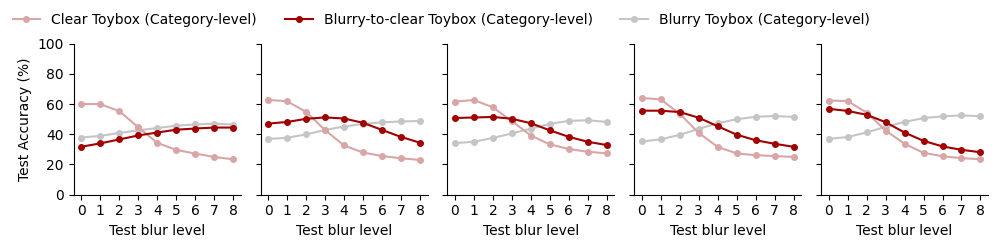

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox12_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

epochs = sorted(metrics.keys())

fig, axes = plt.subplots(1, len(epochs), figsize=(10, 2.5), sharey=True)

blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

handles = []
labels = []

for i, epoch in enumerate(epochs):
    data = metrics[epoch]
    clear_model_accuracies = np.array(data["clear_model_accuracies"]) * 100
    blur_model_accuracies = np.array(data["blur_model_accuracies"]) * 100
    full_blur_model_accuracies = np.array(data["full_blur_model_accuracies_100"]) * 100

    ax = axes[i]
    line1, = ax.plot(blur_sigmas, clear_model_accuracies, label="Clear Toybox (Category-level)", marker="o", markersize=4, linestyle="-", color="#d8a6a6", zorder=2)
    line2, = ax.plot(blur_sigmas, blur_model_accuracies, label="Blurry-to-clear Toybox (Category-level)", marker="o", markersize=4, linestyle="-", color="#a00000", zorder=3)
    line3, = ax.plot(blur_sigmas, full_blur_model_accuracies, label="Blurry Toybox (Category-level)", marker="o", markersize=4, linestyle="-", color="#c5c5c5", zorder=1)

    #ax.set_title(f"σ = {blur_sigmas[::-1][i]}")
    ax.set_xlabel("Test blur level")
    if i == 0:
        handles.extend([line1, line2, line3])
        labels.extend(["Clear Toybox (Category-level)", "Blurry-to-clear Toybox (Category-level)", "Blurry Toybox (Category-level)"])
        ax.set_ylabel("Test Accuracy (%)")

    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(blur_sigmas)

fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit legend properly
plt.show()

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox12_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

data = metrics[100]
print(f"Clear model on blurred input: {data['clear_model_accuracies'][-1] * 100:.2f}%")
print(f"Blur model on clear input: {data['full_blur_model_accuracies_100'][0] * 100:.2f}%")
print(f"Blurry-to-clear model on clear input: {data['blur_model_accuracies'][-1] * 100:.2f}%")

Clear model on blurred input: 23.52%
Blur model on clear input: 36.91%
Blurry-to-clear model on clear input: 28.09%
Blurry-to-clear/clear ratio model on clear input: 119.45%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Toybox-360

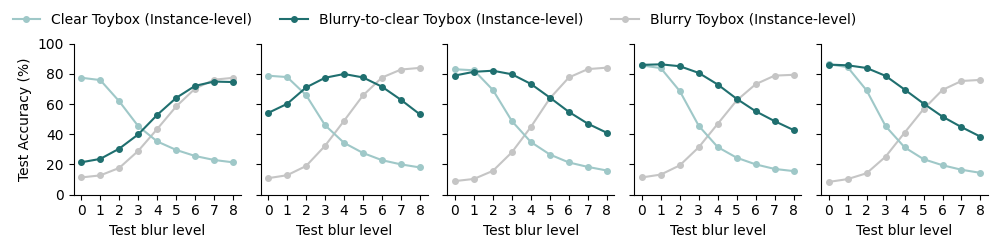

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox360_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

epochs = sorted(metrics.keys())
fig, axes = plt.subplots(1, len(epochs), figsize=(10, 2.5), sharey=True)

blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

handles = []
labels = []

for i, epoch in enumerate(epochs):
    data = metrics[epoch]
    clear_model_accuracies = np.array(data["clear_model_accuracies"]) * 100
    blur_model_accuracies = np.array(data["blur_model_accuracies"]) * 100
    full_blur_model_accuracies = np.array(data["full_blur_model_accuracies_100"]) * 100

    ax = axes[i]
    line1, = ax.plot(blur_sigmas, clear_model_accuracies, label="Clear Toybox (Instance-level)", marker="o", markersize=4, linestyle="-", color="#9fc8c8", zorder=2)
    line2, = ax.plot(blur_sigmas, blur_model_accuracies, label="Blurry-to-clear Toybox (Instance-level)", marker="o", markersize=4, linestyle="-", color="#1f6f6f", zorder=3)
    line3, = ax.plot(blur_sigmas, full_blur_model_accuracies, label="Blurry Toybox (Instance-level)", marker="o", markersize=4, linestyle="-", color="#c5c5c5", zorder=1)

    #ax.set_title(f"σ = {blur_sigmas[::-1][i]}")
    ax.set_xlabel("Test blur level")
    if i == 0:
        handles.extend([line1, line2, line3])
        labels.extend(["Clear Toybox (Instance-level)", "Blurry-to-clear Toybox (Instance-level)", "Blurry Toybox (Instance-level)"])
        ax.set_ylabel("Test Accuracy (%)")

    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #xticks = [tick for tick in blur_sigmas if tick != 6]
    #ax.set_xticks(xticks)
    ax.set_xticks(blur_sigmas)

fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit legend properly
plt.show()

### Facescrub

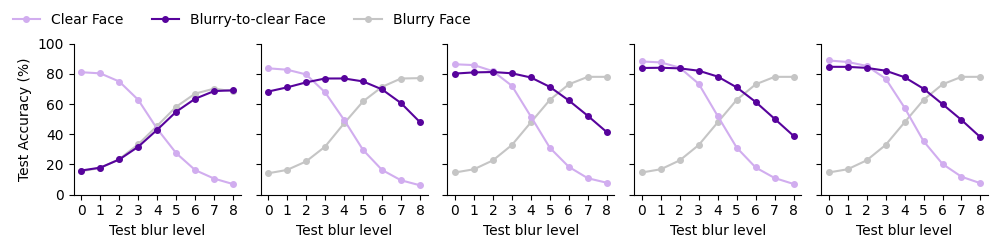

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/facescrub_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

epochs = sorted(metrics.keys())
fig, axes = plt.subplots(1, len(epochs), figsize=(10, 2.5), sharey=True)

blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

handles = []
labels = []

for i, epoch in enumerate(epochs):
    data = metrics[epoch]
    clear_model_accuracies = np.array(data["clear_model_accuracies"]) * 100
    blur_model_accuracies = np.array(data["blur_model_accuracies"]) * 100
    full_blur_model_accuracies = np.array(data["full_blur_model_accuracies_100"]) * 100

    ax = axes[i]
    line1, = ax.plot(blur_sigmas, clear_model_accuracies, label="Clear Face", marker="o", markersize=4, linestyle="-", color="#d1adef", zorder=2)
    line2, = ax.plot(blur_sigmas, blur_model_accuracies, label="Blurry-to-clear Face", marker="o", markersize=4, linestyle="-", color="#57039c", zorder=3)
    line3, = ax.plot(blur_sigmas, full_blur_model_accuracies, label="Blurry Face", marker="o", markersize=4, linestyle="-", color="#c5c5c5", zorder=1)

    #ax.set_title(f"σ = {blur_sigmas[::-1][i]}")
    ax.set_xlabel("Test blur level")
    if i == 0:
        handles.extend([line1, line2, line3])
        labels.extend(["Clear Face", "Blurry-to-clear Face", "Blurry Face"])
        ax.set_ylabel("Test Accuracy (%)")

    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #xticks = [tick for tick in blur_sigmas if tick != 6]
    #ax.set_xticks(xticks)
    ax.set_xticks(blur_sigmas)

fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit legend properly
plt.show()

### IN-12

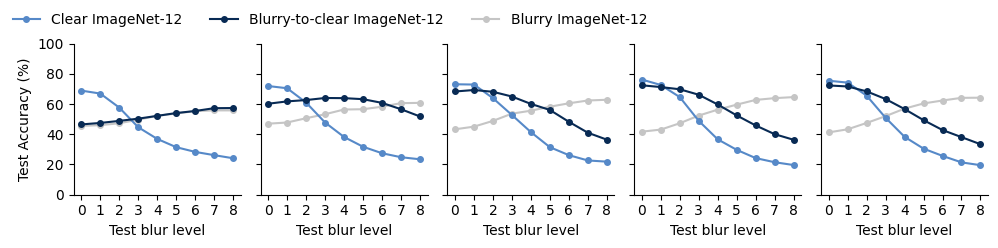

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN12_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

epochs = sorted(metrics.keys())
fig, axes = plt.subplots(1, len(epochs), figsize=(10, 2.5), sharey=True)

blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

handles = []
labels = []

for i, epoch in enumerate(epochs):
    data = metrics[epoch]
    clear_model_accuracies = np.array(data["clear_model_accuracies"]) * 100
    blur_model_accuracies = np.array(data["blur_model_accuracies"]) * 100
    full_blur_model_accuracies = np.array(data["full_blur_model_accuracies_100"]) * 100

    ax = axes[i]
    line1, = ax.plot(blur_sigmas, clear_model_accuracies, label="Clear ImageNet-12 training", marker="o", markersize=4, linestyle="-", color="#5689c8", zorder=2)
    line2, = ax.plot(blur_sigmas, blur_model_accuracies, label="Blurry-to-clear ImageNet-12 training", marker="o", markersize=4, linestyle="-", color="#082a54", zorder=3)
    line3, = ax.plot(blur_sigmas, full_blur_model_accuracies, label="Blurry ImageNet-12 training", marker="o", markersize=4, linestyle="-", color="#c5c5c5", zorder=1)

    #ax.set_title(f"σ = {blur_sigmas[::-1][i]}")
    ax.set_xlabel("Test blur level")
    if i == 0:
        handles.extend([line1, line2, line3])
        labels.extend(["Clear ImageNet-12", "Blurry-to-clear ImageNet-12", "Blurry ImageNet-12"])
        ax.set_ylabel("Test Accuracy (%)")

    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #xticks = [tick for tick in blur_sigmas if tick != 6]
    #ax.set_xticks(xticks)
    ax.set_xticks(blur_sigmas)


fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit legend properly
plt.show()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN12_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

data = metrics[100]
print(f"Clear model on blurred input: {data['clear_model_accuracies'][-1] * 100:.2f}%")
print(f"Blur model on clear input: {data['full_blur_model_accuracies_100'][0] * 100:.2f}%")

Clear model on blurred input: 19.53%
Blur model on clear input: 41.21%


### ImageNet-100

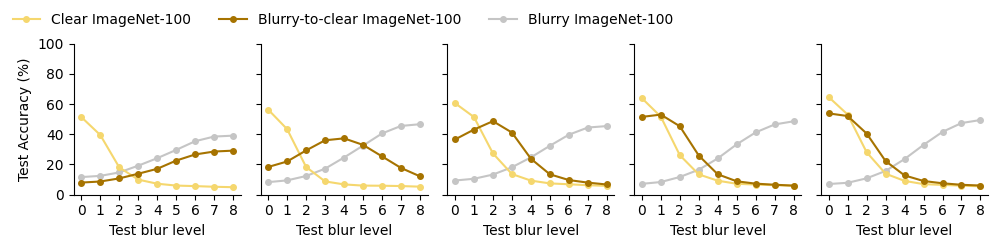

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved pickle file
file_path = "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN100_epochwise_results.pkl"
with open(file_path, "rb") as f:
    metrics = pickle.load(f)

epochs = sorted(metrics.keys())
fig, axes = plt.subplots(1, len(epochs), figsize=(10, 2.5), sharey=True)

blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

handles = []
labels = []

for i, epoch in enumerate(epochs):
    data = metrics[epoch]
    clear_model_accuracies = np.array(data["clear_model_accuracies"]) * 100
    blur_model_accuracies = np.array(data["blur_model_accuracies"]) * 100
    full_blur_model_accuracies = np.array(data["full_blur_model_accuracies_100"]) * 100

    ax = axes[i]
    line1, = ax.plot(blur_sigmas, clear_model_accuracies, label="Clear ImageNet-100 training", marker="o", markersize=4, linestyle="-", color="#f5d76e", zorder=2)
    line2, = ax.plot(blur_sigmas, blur_model_accuracies, label="Blurry-to-clear ImageNet-100 training", marker="o", markersize=4, linestyle="-", color="#a67300", zorder=3)
    line3, = ax.plot(blur_sigmas, full_blur_model_accuracies, label="Blurry ImageNet-100 training", marker="o", markersize=4, linestyle="-", color="#c5c5c5", zorder=1)

    #ax.set_title(f"σ = {blur_sigmas[::-1][i]}")
    ax.set_xlabel("Test blur level")
    if i == 0:
        handles.extend([line1, line2, line3])
        labels.extend(["Clear ImageNet-100", "Blurry-to-clear ImageNet-100", "Blurry ImageNet-100"])
        ax.set_ylabel("Test Accuracy (%)")

    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #xticks = [tick for tick in blur_sigmas if tick != 6]
    #ax.set_xticks(xticks)
    ax.set_xticks(blur_sigmas)

fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## Blurry-to-clear vs Clear Accuracy ratio

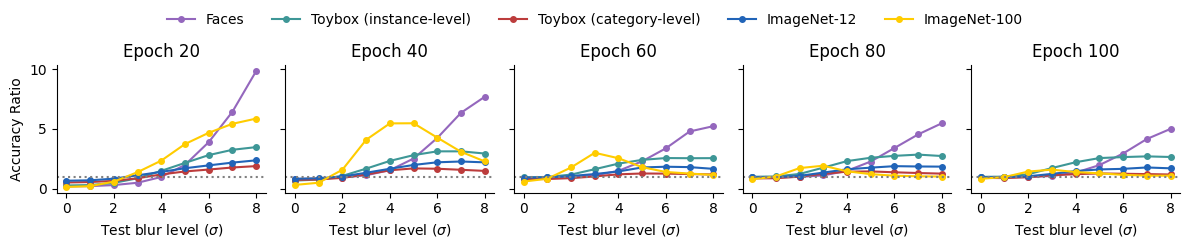

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

datasets = [
    {
        "file": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/facescrub_epochwise_results.pkl",
        "label": "Faces",
        "color": "#9467bd"
    },
    {
        "file": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox360_epochwise_results.pkl",
        "label": "Toybox (instance-level)",
        "color": "#3e9797"
    },
    {
        "file": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox12_epochwise_results.pkl",
        "label": "Toybox (category-level)",
        "color": "#bc3c3c"
    },
    {
        "file": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN12_epochwise_results.pkl",
        "label": "ImageNet-12",
        "color": "#2164b8"
    },
    {
        "file": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN100_epochwise_results.pkl",
        "label": "ImageNet-100",
        "color": "#ffcc00"
    }
]


# Define the selected epochs and test blur levels
selected_epochs = [20, 40, 60, 80, 100]
blur_sigmas = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
sigma_mapping = {20: 8, 40: 4, 60: 2, 80: 1, 100: 0}

# Pre-load metrics for each dataset
for ds in datasets:
    with open(ds["file"], "rb") as f:
        ds["metrics"] = pickle.load(f)

# Create one subplot per selected epoch
fig, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey=True)

for ax, epoch in zip(axes, selected_epochs):
    for ds in datasets:
        metrics = ds["metrics"]
        # Check if the selected epoch is available for the dataset
        if epoch in metrics:
            data = metrics[epoch]
            clear_acc = np.array(data["clear_model_accuracies"])
            blur_acc = np.array(data["blur_model_accuracies"])
            # Compute ratio (unitless)
            ratio = blur_acc / clear_acc
            ax.plot(blur_sigmas, ratio, marker="o", markersize=4, linestyle="-", color=ds["color"], label=ds["label"])

    sigma_value = sigma_mapping.get(epoch, "unknown")
    ax.set_title(f"Epoch {epoch}")
    ax.set_xlabel("Test blur level ($\sigma$)")
    if ax == axes[0]:
        ax.set_ylabel("Accuracy Ratio")

    ax.axhline(y=1, color="gray", linestyle="dotted")

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a single combined legend for all datasets
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(datasets), frameon=False)

#plt.suptitle("Training Ratio (Blurry-to-clear / Clear) Accuracies Across Datasets")
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

## Accuracy ratio as a function of minibatch number

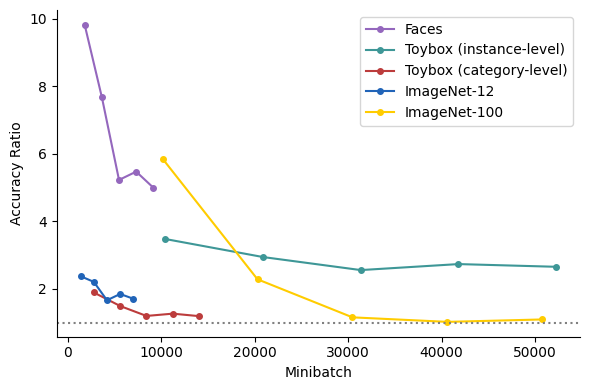

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Assumed test blur levels (0 to 8)
blur_sigmas = np.arange(9)

def get_accuracy_difference(file_path, total_minibatches, test_blur=8):
    """
    Load the pickle file with metrics, and for each training stage (every 20 epochs),
    compute:
      - the corresponding minibatch number (assuming epoch 100 equals total_minibatches),
      - and the difference between the Blurry-to-clear and Clear model accuracies at the specified test blur level.

    Parameters:
        file_path (str): Path to the pickle file containing metrics.
        total_minibatches (int): Total number of minibatches for the model.
        test_blur (int): Test blur level at which to compute the accuracy difference.

    Returns:
        x_values (list): Minibatch numbers corresponding to each training stage.
        differences (list): Accuracy differences (in percentage points) at the specified blur level.
    """
    with open(file_path, "rb") as f:
        metrics = pickle.load(f)

    # Expect metrics keys to be epochs: 20, 40, 60, 80, 100
    epochs = sorted(metrics.keys())
    differences = []
    x_values = []

    # Find the index corresponding to the desired test blur level
    try:
        test_index = np.where(blur_sigmas == test_blur)[0][0]
    except IndexError:
        raise ValueError("The specified test blur level is not found in the blur_sigmas array.")

    for epoch in epochs:
        # Compute corresponding minibatch number.
        # Epoch 100 corresponds to total_minibatches, so scale accordingly.
        minibatch_num = total_minibatches * (epoch / 100.0)
        data = metrics[epoch]
        clear_acc = np.array(data["clear_model_accuracies"]) * 100
        blur_acc = np.array(data["blur_model_accuracies"]) * 100

        # Compute difference at the specified test blur level
        diff = blur_acc[test_index] / clear_acc[test_index]

        x_values.append(minibatch_num)
        differences.append(diff)

    return x_values, differences

# Define the datasets information using the correct total minibatch numbers
datasets_info = [
    {"file_path": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/facescrub_epochwise_results.pkl",
     "label": "Faces",
     "color": "#9467bd",
     "total_minibatches": 9175},   # 23,488 / 256 * 100 = 9,175
    {"file_path": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox360_epochwise_results.pkl",
     "label": "Toybox (instance-level)",
     "color": "#3e9797",
     "total_minibatches": 52252},  # 36,000 / 256 * 100 ≈ 14,063
    {"file_path": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/toybox12_epochwise_results.pkl",
     "label": "Toybox (category-level)",
     "color": "#bc3c3c",
     "total_minibatches": 14063},  # 133,644 / 256 * 100 ≈ 52,252
    {"file_path": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN12_epochwise_results.pkl",
     "label": "ImageNet-12",
     "color": "#2164b8",
     "total_minibatches": 7032},   # 18,000 / 256 * 100 ≈ 7,032
    {"file_path": "/content/drive/MyDrive/ug-project/output/alexnet/plotting_data/IN100_epochwise_results.pkl",
        "label": "ImageNet-100",
        "color": "#ffcc00",
     "total_minibatches": 50781},  # 130,000 / 256 * 100 ≈ 50,781
]

plt.figure(figsize=(6, 4))

# Loop over each dataset, compute x-values (minibatch numbers) and accuracy differences, then plot
for ds in datasets_info:
    x_vals, diffs = get_accuracy_difference(ds["file_path"], ds["total_minibatches"], test_blur=8)
    plt.plot(x_vals, diffs, marker="o", markersize=4, linestyle="-", color=ds["color"], label=ds["label"])
plt.axhline(y=1, color="gray", linestyle="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Minibatch")
plt.ylabel("Accuracy Ratio")
#plt.title("Difference in Test Accuracy at Blur Level 8 vs. Training Progress")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()